# **4. Data Modeling:**
## 🎯 **Goal:**
Our Data Science project focuses on weather and air quality analysis. Initially, the plan was to build a web application that predicts multiple time-series features, integrates them into a classification model to forecast weather status, and use a simple chatbot to provide advice and recommendation to user. However, predicting multiple time series proved challenging, and the dataset crawled is not large enough to establish seasonal trends, making it difficult for models to capture patterns effectively. As a result, the scope was narrowed to two models: one for US AQI time-series prediction and another for weather status classification. Finally, the chatbot is employed to deliver personalized advice based on the predictions.

# **4.1. Time Series Forecasting for US AQI** 🌟

## 0. Problem Definition:

### 🎯 **Goal:**  
The objective of this task is to **predict the Air Quality Index (AQI)** of the United States (US) for a **user-defined forecast horizon** (3, 5, or 7 days) using **time series forecasting models**. This is a **single-variable forecasting problem**, where the model uses **past AQI values** to predict future AQI values without any additional input features.

---

### 🔍 **Step 1: Model Experimentation** 

- **Task:** Evaluate and experiment with the following time series forecasting models for predicting the US AQI (target variable). The models to be considered are:
  - **ARIMA (AutoRegressive Integrated Moving Average)**
  - **Random Forest Regressor** (with **recursive strategy** using `sktime`)
  - **XGBoost** (with **recursive strategy** using `sktime`)

> **Why Recursive?**  
> **Recursive forecasting** *works well for time series data because it mimics the way forecasting naturally works in practice: after predicting the first step, the prediction is refined and updated with each new forecast. This is especially useful when predicting multiple steps ahead, as each prediction uses information from the previous steps.*

- **Purpose:** The aim is to identify which model **best captures** the underlying patterns and trends in the AQI time series data.

- **Important Consideration:** This is a **single-variable forecasting task**, meaning the models will only use the **historical AQI values** (target variable) to predict future AQI values. **No external input features** (such as weather or geographical data) will be included.

---

### 📊 **Step 2: Model Evaluation and Comparison**

- **Task:** After evaluating the models, compare their forecasting performance by using the **Mean Absolute Error (MAE)** metric over a **7-day forecast horizon** (maximum forecast period).  
> **Why MAE?**  
> Because it is simple, interpretable, robust, and does not disproportionately penalize outliers, making it well-suited for evaluating time series models.
  - **Prediction Horizon:** Forecast AQI for the next **7 days**, then calculate the MAE to assess the accuracy of each model's predictions.

- **Visualization:** Use visualization techniques (e.g., **line plots**) to compare the predicted AQI values with the actual AQI values for each model. This will help in assessing how well each model **captures the trend** of the data and its **prediction consistency**.

---

### 🏆 **Step 3: Model Selection and Implementation**

- **Task:** Select the model with the **best performance** based on both **MAE scores** and **visual trend consistency** (how well the model captures the AQI trend).

- **Goal:** Once the best-performing model is identified, build a **reusable function** or script that allows for future forecasting of the US AQI for any given forecast horizon (3, 5, or 7 days), with the ability to **update the model on a daily basis** using the most recent data.

---

### ✨ **Summary of Objectives:**


This approach will ensure that the best forecasting model for AQI is chosen based on its **prediction accuracy** and its ability to capture the underlying trends in the data.


# 1. Libraries


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sklearn.metrics import mean_absolute_error

import joblib
import os

# 2. Load dataset

In [4]:
file_path = '../data/clean_hcmc_waq.csv' 
data = pd.read_csv(file_path, parse_dates=['date_time'], index_col='date_time')

data.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,cloud_cover,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,us_aqi,weather_status
date_time,,,,,,,,,,,,,,,,,
2022-10-01 07:00:00,25.511000,94.49476,24.561,31.543438,1.3,100.0,0.179606,2.902413,209.74480,61.2,42.1,1123.0,50.80,11.50,4.0,73.652490,Light Rain
2022-10-01 08:00:00,26.411001,88.26100,24.311,31.320229,0.6,100.0,0.403905,9.504272,232.69597,36.9,24.9,906.0,43.05,11.25,14.0,76.471634,Moderate Drizzle
2022-10-01 09:00:00,26.911001,88.03870,24.761,32.211530,0.7,100.0,0.423807,8.788720,214.99210,28.0,18.5,598.0,31.95,10.90,27.0,77.597520,Moderate Drizzle
2022-10-01 10:00:00,28.011000,85.29904,25.311,33.920822,0.6,100.0,0.555415,7.072878,194.74360,24.2,15.9,281.0,19.70,10.50,48.0,78.182625,Moderate Drizzle
2022-10-01 11:00:00,29.011000,78.12226,24.811,34.491055,0.4,100.0,0.875935,7.754637,201.80147,26.0,17.1,213.0,14.25,10.50,67.0,78.430855,Light Drizzle


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2022-10-01 07:00:00 to 2024-10-01 06:00:00
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   temperature_2m           17544 non-null  float64
 1   relative_humidity_2m     17544 non-null  float64
 2   dew_point_2m             17544 non-null  float64
 3   apparent_temperature     17544 non-null  float64
 4   precipitation            17544 non-null  float64
 5   cloud_cover              17544 non-null  float64
 6   vapour_pressure_deficit  17544 non-null  float64
 7   wind_speed_10m           17544 non-null  float64
 8   wind_direction_10m       17544 non-null  float64
 9   pm10                     17544 non-null  float64
 10  pm2_5                    17544 non-null  float64
 11  carbon_monoxide          17544 non-null  float64
 12  nitrogen_dioxide         17544 non-null  float64
 13  sulphur_dioxide          17544 non-null  

# 3. General Preprocess

## 1. Create lag features

Create 6 lag feature of `us_aqi` as *six previous hourly values* of **target** to make more accurate prediction

In [6]:
n_prev_hours = 6

def create_features(data, n_lags=n_prev_hours):
    """
    This function generates lag features from the 'us_aqi' time series data.
    Each lag feature represents the previous hour's AQI value, creating a 
    comprehensive view of the past behavior of the time series for better prediction accuracy.
    """
    df = pd.DataFrame()
    for i in range(n_lags):
        df[f'lag_{i+1}'] = data['us_aqi'].shift(i+1)
    df['target'] = data['us_aqi']
    return df.dropna()

df_features = create_features(data)
df_features.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,target
date_time,,,,,,,
2022-10-01 13:00:00,78.625890,78.430855,78.182625,77.597520,76.471634,73.652490,79.157810
2022-10-01 14:00:00,79.157810,78.625890,78.430855,78.182625,77.597520,76.471634,79.698586
2022-10-01 15:00:00,79.698586,79.157810,78.625890,78.430855,78.182625,77.597520,79.991135
2022-10-01 16:00:00,79.991135,79.698586,79.157810,78.625890,78.430855,78.182625,80.372340
2022-10-01 17:00:00,80.372340,79.991135,79.698586,79.157810,78.625890,78.430855,81.214540


## 2. Train test split

In [7]:
X = df_features.iloc[:, :-1].asfreq('h')
y = df_features['target'].asfreq('h')

test_size = 7*24
train_size = len(X) - test_size

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 17370, Test size: 168


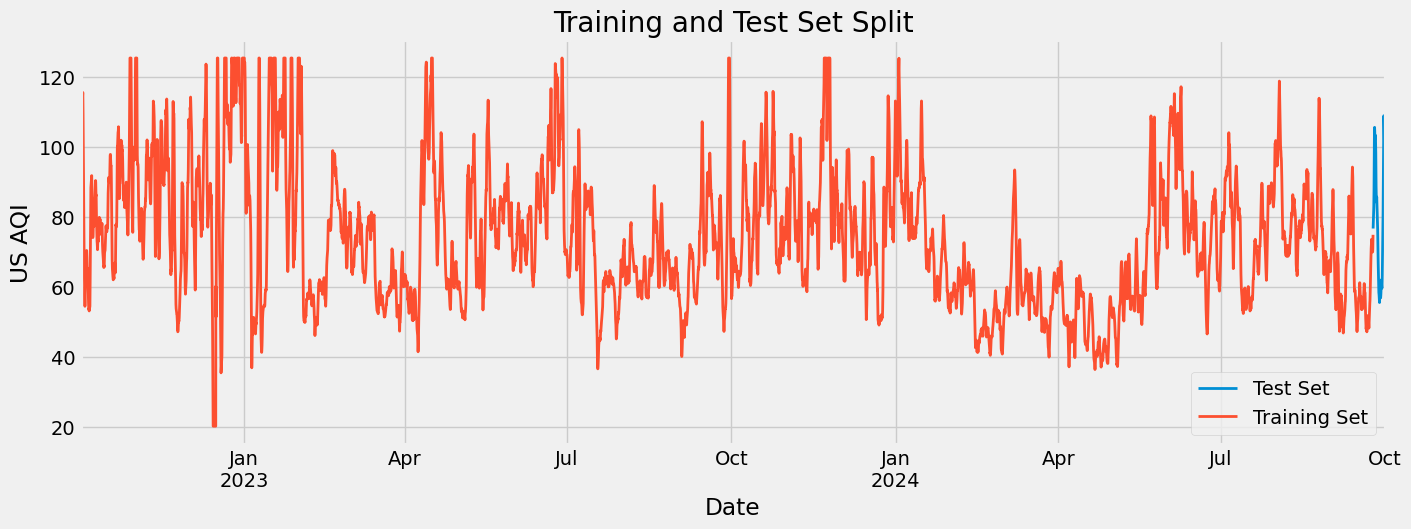

In [8]:
_ = y_test.to_frame(name='Test Set') \
    .join(y_train.to_frame(name='Training Set'), how='outer') \
    .plot(figsize=(15, 5),linewidth=2)  

plt.xlabel('Date')
plt.ylabel('US AQI')
plt.title('Training and Test Set Split')
plt.show()

# 4. Model Experimentation

## 1. ARIMA

In [9]:
arima = ARIMA(y_train, order=(5, 1, 1))
arima_fit = arima.fit()
arima_predictions = arima_fit.forecast(steps=test_size)

arima_mae = mean_absolute_error(y_test, arima_predictions)

print(f"ARIMA MAE: {arima_mae}")

ARIMA MAE: 15.196950618698287


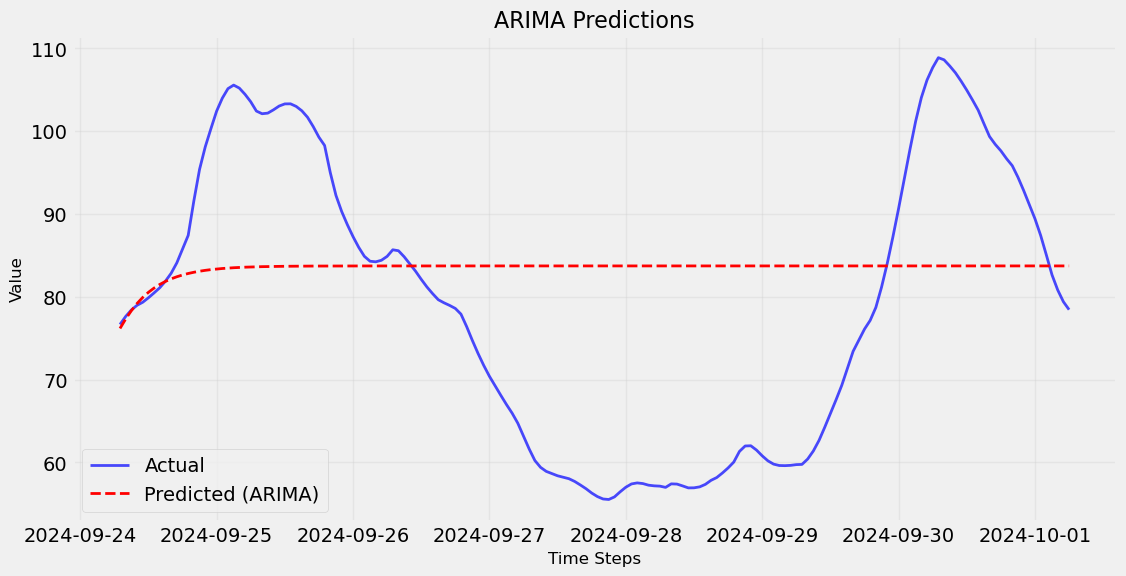

In [10]:

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual", color="blue", linewidth=2, alpha=0.7)
plt.plot(y_test.index, arima_predictions, label="Predicted (ARIMA)", color="red", linestyle="--", linewidth=2)
plt.title("ARIMA Predictions", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

The ARIMA model showed a good forcasting in serveral first hours. However, it tend to predict values close to the average after a few initial hours, failing to capture extreme values or sudden changes in the data. This makes ARIMA less effective for long-term forecasting in this datasets with significant volatility. 

> Overall, ARIMA doesn't fit this dataset which doesn't have clear pattern.

## 2. Random Forest Regressor

In [11]:
fh = ForecastingHorizon(np.arange(1, len(y_test) + 1), is_relative=True)


rf = RandomForestRegressor(
    n_estimators=100,       # Số lượng cây quyết định
    max_depth=None,         # Độ sâu tối đa của cây (không giới hạn)
    min_samples_split=2,    # Số lượng mẫu tối thiểu để phân chia nút
    min_samples_leaf=1,     # Số lượng mẫu tối thiểu trong mỗi lá
    bootstrap=True,         # Chọn mẫu ngẫu nhiên (bootstrap sampling)
    random_state=42        # Đảm bảo tái tạo được kết quả
)

rf_forecaster = make_reduction(
    rf, 
    strategy="recursive"
)

rf_forecaster.fit(y_train)

y_pred = rf_forecaster.predict(fh)
rf_mae = mean_absolute_error(y_test, y_pred)

print(f"Random Forest MAE: {rf_mae}")

Random Forest MAE: 14.52935122180952


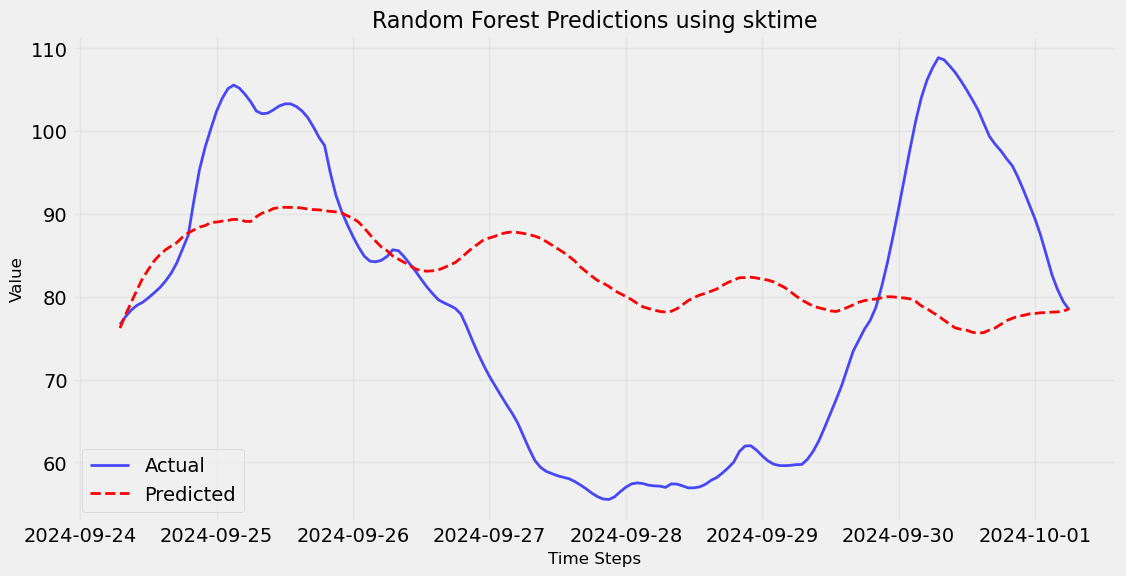

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual", color="blue", linewidth=2, alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicted", color="red", linestyle="--", linewidth=2)
plt.title("Random Forest Predictions using sktime", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

The model predicts accurately during the initial time steps, closely following the actual data trends. This demonstrates its ability to capture immediate patterns effectively. The model struggles to respond to abrupt changes and extreme values in the data. It tends to predict values that hover around the overall trend, indicating a mean-regression behavior.

> While Random Forest works well for capturing general trends, it is not the best choice for this dataset due to its inability to handle sudden shifts or extremes in the data.

## 3. XGBoost Regressor

In [13]:
fh = ForecastingHorizon(np.arange(1, len(y_test) + 1), is_relative=True)

# Hyperparameters for the XGBoost model
xgb = XGBRegressor(
    n_estimators=500,       # Number of trees
    learning_rate=0.1,      # Learning rate
    max_depth=7,            # Maximum depth of trees
    subsample=0.8,          # Subsample ratio
    colsample_bytree=0.8,   # Column sample ratio
    gamma=0.1,              # Gamma value for pruning
    min_child_weight=1,     # Minimum child weight for splitting
    random_state=42         # Set random state for reproducibility
)

xgb_forecaster = make_reduction(xgb, strategy="recursive")

xgb_forecaster.fit(y_train)
y_pred = xgb_forecaster.predict(fh)

xgb_mae = mean_absolute_error(y_test, y_pred)

print(f"XGBoost MAE: {xgb_mae}")

XGBoost MAE: 13.383442226385206


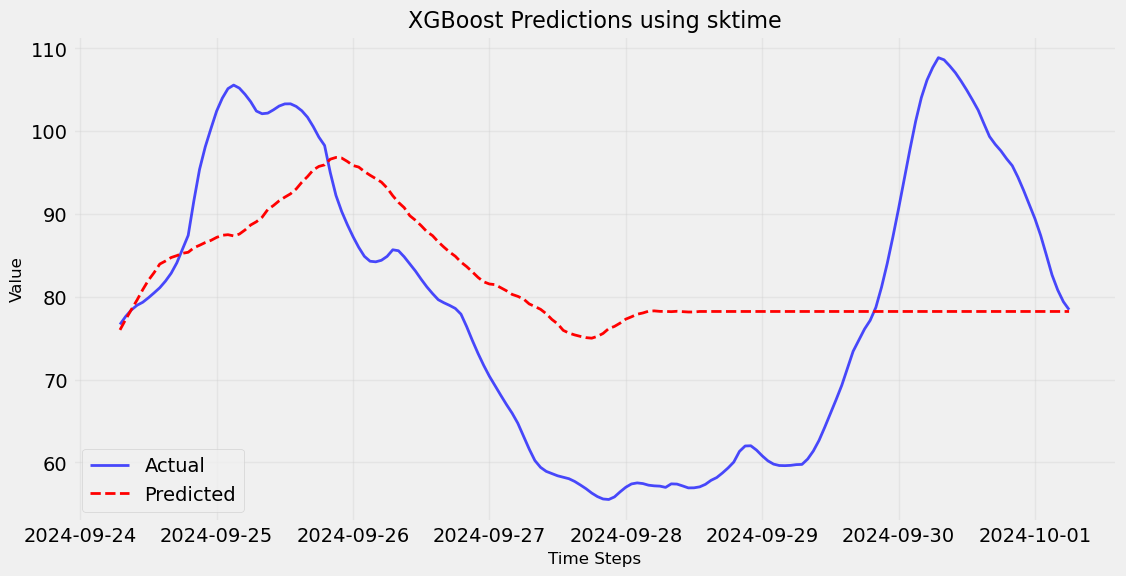

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual", color="blue", linewidth=2, alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicted", color="red", linestyle="--", linewidth=2)
plt.title("XGBoost Predictions using sktime", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

The XGBoost model shows good performance initially, accurately predicting trends in the early time steps. This indicates that the model captures the immediate dynamics well.
Since the model relies on its own previous predictions (recursive approach), errors accumulate over time, leading to less accurate forecasts in the long term.
This recursive method causes the model to predict values close to the mean, making it ineffective in capturing extreme values or sharp fluctuations.

> Even though XGBoost so far have the best performance among these three, its performance deteriorates over time, making it unsuitable for volatile datasets.

# 5. Model Evaluation and Comparison

In [15]:
results = {
    'ARIMA': arima_mae,
    'Random Forest': rf_mae,
    'XGBoost': xgb_mae
}

for model, mae in results.items():
    print(f"{model}: MAE = {mae}")

ARIMA: MAE = 15.196950618698287
Random Forest: MAE = 14.52935122180952
XGBoost: MAE = 13.383442226385206


> Base on model's metrics and its performance, XGBoost seems to be the most suitable model for this problem on this dataset.

In [21]:
model_path = '../model/ts_forecasting_model.pkl'
joblib.dump(xgb_forecaster, model_path)

['../model/ts_forecasting_model.pkl']

# 6. Model Implementation

In [22]:
def predict_aqi(model_path, pred_days=7):
    if os.path.exists(model_path):
        forecaster = joblib.load(model_path)
    else:
        return False

    pred_range = pred_days * 24
    fh = ForecastingHorizon(np.arange(1, pred_range + 1), is_relative=True)
    y_pred = forecaster.predict(fh)

    return y_pred

In [23]:
predict_aqi(model_path, 7)

2024-09-24 07:00:00    76.005814
2024-09-24 08:00:00    77.271713
2024-09-24 09:00:00    78.456421
2024-09-24 10:00:00    79.613235
2024-09-24 11:00:00    80.861282
                         ...    
2024-10-01 02:00:00    78.232224
2024-10-01 03:00:00    78.232224
2024-10-01 04:00:00    78.232224
2024-10-01 05:00:00    78.232224
2024-10-01 06:00:00    78.232224
Freq: h, Name: target, Length: 168, dtype: float64